# Basic Training and Prediction with Pytorch CNN's

In [51]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor
# from opensoundscape.torch.models.resnet_binary import ResnetBinaryModel
from opensoundscape.torch.models.cnn import PytorchModel, Resnet18Multiclass, Resnet18Binary
from opensoundscape.helpers import run_command

import torch
import torchvision.models

import yaml
import os.path
import pandas as pd
from pathlib import Path
from math import floor

from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.helpers import run_command


import numpy as np
import pandas as pd
import random 

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

## Prepare audio data

### Download labeled audio files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's "Raven" sound analysis software.

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

In [52]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

KeyboardInterrupt: 

### Inspect the data

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

Look at the contents of `woodcock_labels.csv`. First, load them into a `pandas` DataFrame called `labels`. Use `labels.shape` to see how many audio files there are.

In [16]:
labels = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
labels.filename = ['./woodcock_labeled_data/'+f for f in labels.filename]

labels['negative']=[0 if label=='present' else 1 for label in labels['woodcock']]
labels['positive']=[1 if label=='present' else 0 for label in labels['woodcock']]
labels = labels.set_index('filename')[['negative','positive']]
labels.head()

,negative,positive
filename,,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0,1
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1,0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0,1
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1


In [17]:
from sklearn.model_selection import train_test_split
train_df,valid_df = train_test_split(labels,test_size=0.2,random_state=0)
# for multi-class need at least a few images for each batch
len(train_df)

23

# Preprocessors

In [18]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df, overlay_df=train_df)

valid_dataset = CnnPreprocessor(valid_df,overlay_df=valid_df,return_labels=True)

inspect / modify preprocessing pipeline

tweak preprocessing

In [7]:
train_dataset.actions.load_audio.set(sample_rate=22050)

In [8]:
# train_dataset.actions.overlay.off()
train_dataset.actions.overlay.set(update_labels=True)
train_dataset.actions.overlay.set(overlay_class=None)
train_dataset.actions.overlay.set(overlay_weight=0.5)


train_dataset.actions.time_mask.off()
# train_dataset.actions.frequency_mask.set(max_width = 0.3, max_masks=5)
train_dataset.actions.frequency_mask.off()

train_dataset.actions.random_affine.off()
train_dataset.actions.random_affine.set(fill=0)

train_dataset.actions.add_noise.off()

# train_dataset.actions.normalize.set(mean=.73,std=0.13)
# train_dataset.actions.normalize.off()

train_dataset.actions.color_jitter.off()

train_dataset.actions.bandpass.set(min_f=0,max_f=2000)
train_dataset.actions.bandpass.off()

## inspect training images

subset with:

`dataset.sample(n=10)`

`dataset.sample(frac=0.1)`

`dataset.head(10)`

In [53]:
def show_tensor(return_val):
    plt.imshow((return_val['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

labels: tensor([0, 1])


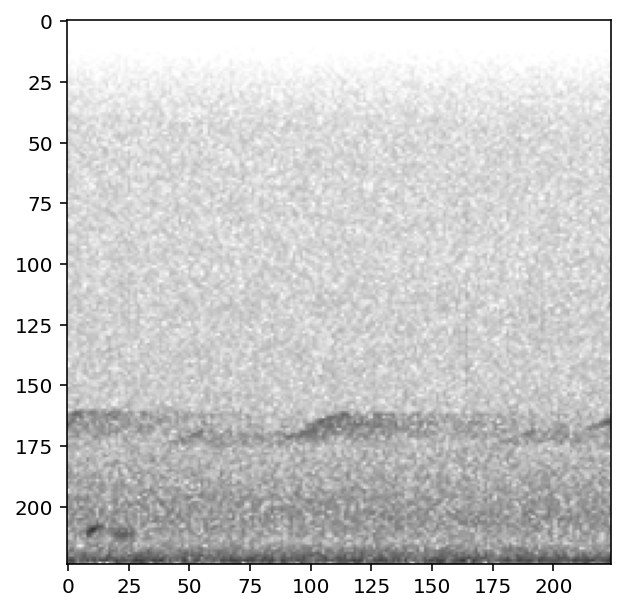

labels: tensor([0, 1])


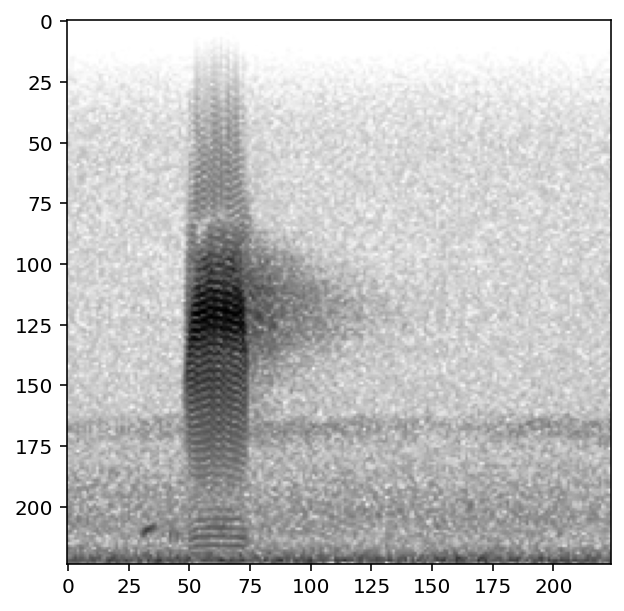

In [54]:
for i, d in enumerate(train_dataset.sample(n=2)):
    print(f"labels: {d['y']}")
    show_tensor(d)

## Train

In [55]:
from opensoundscape.torch.models.cnn import Resnet18Binary

In [56]:
# Set up architecture for the type of model we will use
model = Resnet18Binary()

created PytorchModel model object with 2 classes


### modify training parameters

In [57]:
model.lr_feature=.01
# model.weight_decay_feature = .0005 #acts ~ L2 regularization factor
model.momentum_feature=0

model.lr_classifier=.01
# model.weight_decay_classifier = .0005 #acts ~ L2 regularization factor
model.momentum_classifier=0

#learning rate schedule:
#multiply the learning rates by gamma after every step_size epochs
model.gamma = 0.7
model.step_size = 10 

quickly overtrain by turning off augmentation

In [58]:
train_dataset.augmentation_off()
# train_dataset.actions.overlay.off()
# train_dataset.actions.overlay.set(update_labels=False)
# train_dataset.actions.time_mask.off()
# train_dataset.actions.frequency_mask.off()
# train_dataset.actions.add_noise.off()
# train_dataset.actions.color_jitter.off()
# train_dataset.actions.random_affine.off()

### train

In [59]:
model.train(train_dataset,train_dataset,save_path='.',epochs=5,batch_size=8,save_interval=100,num_workers=0)

Epoch: 0 [batch 0/3 (0.00%)] 
	Jacc: 0.312 Hamm: 0.375 DistLoss: 0.669

Validation.
(23, 2)
	 Precision: 0.782608695652174
	 Recall: 1.0
	 F1: 0.878048780487805
Updating best model
Saving to best.model
Epoch: 1 [batch 0/3 (0.00%)] 
	Jacc: 0.438 Hamm: 0.125 DistLoss: 0.303

Validation.
(23, 2)
	 Precision: 0.782608695652174
	 Recall: 1.0
	 F1: 0.878048780487805
Epoch: 2 [batch 0/3 (0.00%)] 
	Jacc: 0.312 Hamm: 0.375 DistLoss: 0.536

Validation.
(23, 2)
	 Precision: 0.782608695652174
	 Recall: 1.0
	 F1: 0.878048780487805
Epoch: 3 [batch 0/3 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.256

Validation.
(23, 2)
	 Precision: 0.8181818181818182
	 Recall: 1.0
	 F1: 0.9
Updating best model
Saving to best.model
Epoch: 4 [batch 0/3 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.142

Validation.
(23, 2)
	 Precision: 0.782608695652174
	 Recall: 1.0
	 F1: 0.878048780487805
Saving weights, metrics, and train/valid scores.
Saving to epoch-4.model

Best Model Appears at Epoch 3 with F1 0.900.


# Prediction
We haven't actually trained a good model, but we can demonstrate how prediction works:

In [60]:
valid_scores, _,_ = model.predict(valid_dataset,batch_size=2,activation_layer='softmax')
valid_scores.columns = ['pred_negative','pred_positive']
valid_dataset.df.join(train_scores)

(6, 2)


,negative,positive,pred_negative,pred_positive
filename,,,,
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0,1,NaN,NaN
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0,1,NaN,NaN
./woodcock_labeled_data/e9e7153d11de3ac8fc3f7164d43bac92.wav,0,1,NaN,NaN
./woodcock_labeled_data/863095c237c52ec51cff7395d70cee41.wav,0,1,NaN,NaN
./woodcock_labeled_data/cd0b8d8a89321046e96abee21a5527ca.wav,1,0,NaN,NaN
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1,0,NaN,NaN


plot the loss history

Text(0, 0.5, 'loss')

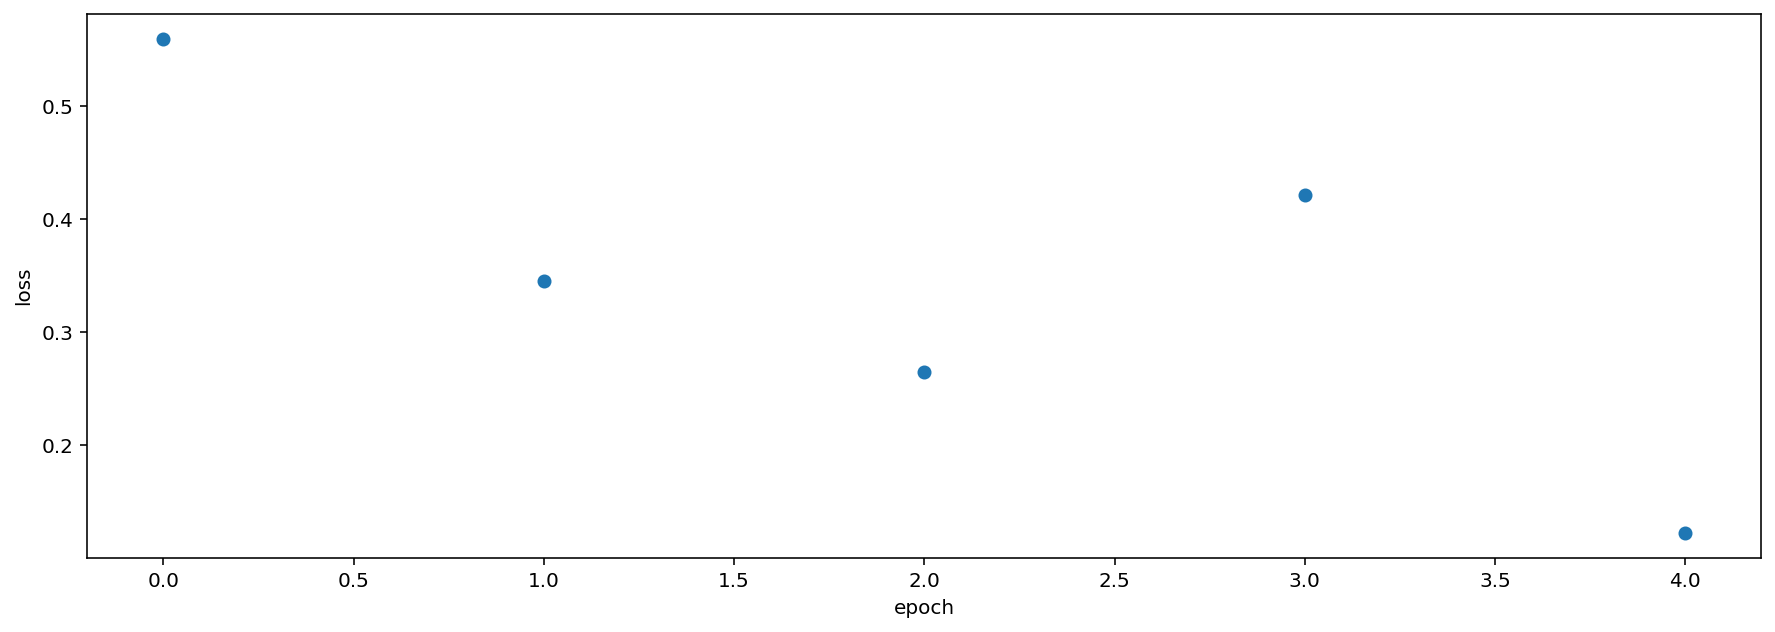

In [61]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

## various prediction modes

single-target prediction

In [62]:
scores,preds,labels = model.predict(train_dataset,activation_layer=None,num_workers=0,binary_preds='single_target')

(23, 2)


multi-target prediction

In [63]:
score_df,pred_df,label_df = model.predict(valid_dataset,binary_preds='multi_target')

(6, 2)


batch size and parallelization (num workers):

In [64]:
score_df,pred_df,label_df = model.predict(valid_dataset,batch_size=8,num_workers=0,binary_preds='multi_target')

(6, 2)


softmax activation layer

In [65]:
score_df,_,_ = model.predict(valid_dataset,activation_layer='softmax')

(6, 2)


softmax activation layer then logit

In [66]:
score_df,_,_ = model.predict(valid_dataset,activation_layer='softmax_and_logit')
score_df

(6, 2)


,negative,positive
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,-3.594395,3.594396
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,-6.064164,6.064152
./woodcock_labeled_data/e9e7153d11de3ac8fc3f7164d43bac92.wav,-9.899078,9.899702
./woodcock_labeled_data/863095c237c52ec51cff7395d70cee41.wav,-5.522697,5.522701
./woodcock_labeled_data/cd0b8d8a89321046e96abee21a5527ca.wav,-3.759527,3.759525
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,-3.432423,3.432423


# train a multi-class multi-label model

In [67]:
from opensoundscape.torch.models.cnn import Resnet18Multiclass

In [68]:
# Set up architecture for the type of model we will use
model = Resnet18Multiclass(['negative','positive'])
model.single_target = False

created PytorchModel model object with 2 classes


### modify training parameters

In [ ]:
model.lr_feature=.01
# model.weight_decay_feature = .0005 #acts ~ L2 regularization factor
model.momentum_feature=0

model.lr_classifier=.01
# model.weight_decay_classifier = .0005 #acts ~ L2 regularization factor
model.momentum_classifier=0

#learning rate schedule:
#multiply the learning rates by gamma after every step_size epochs
model.gamma = 0.7
model.step_size = 10 

### train

In [ ]:
model.train(train_dataset,valid_dataset,save_path='./multilabel_train/',epochs=2,batch_size=16,save_interval=100,num_workers=0)

In [ ]:
model.network.train()
for batch_idx, item in enumerate(model.train_loader):
    # load a batch of images and labels from the train loader
    # all augmentation occurs in the Preprocessor (train_loader)
    data, labels = item["X"].to(model.device), item["y"].to(model.device)
    labels = labels.squeeze(1)

    # forward pass: feature extractor and classifier
    feats = model.network.feature(data)  # feature extraction
    logits = model.network.classifier(feats)  # classification

logits

In [ ]:
model.network.eval()
for batch_idx, item in enumerate(model.train_loader):
    # load a batch of images and labels from the train loader
    # all augmentation occurs in the Preprocessor (train_loader)
    data, labels = item["X"].to(model.device), item["y"].to(model.device)
    labels = labels.squeeze(1)

    # forward pass: feature extractor and classifier
    feats = model.network.feature(data)  # feature extraction
    logits = model.network.classifier(feats)  # classification

logits

In [ ]:
train_preds,_,_ = model.predict(train_dataset,num_workers=0,activation_layer=None)#'softmax_and_logit')
train_preds.columns = ['pred_negative','pred_positive']
train_dataset.df.join(train_preds).sample(5)

In [ ]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

# Load a saved model and predict

In [70]:
from opensoundscape.torch.models.cnn import Resnet18Binary

In [72]:
#create model object then load weights from checkpoint
model = Resnet18Binary()
model.load('./best.model')


created PytorchModel model object with 2 classes
loading weights from saved object
created PytorchModel model object with 2 classes
loading weights from saved object


In [73]:
#alternatively, with same result, create object directly from checkpoint
model = Resnet18Binary.from_checkpoint('./best.model')

created PytorchModel model object with 2 classes
loading weights from saved object


### use saved model to run predictions

In [75]:
scores,_,_ = model.predict(train_dataset)

(23, 2)


In [77]:
scores.head()

,negative,positive
./woodcock_labeled_data/78654b6f687d7635f50fba3546c7bdfa.wav,-1.900971,1.708335
./woodcock_labeled_data/0d043e9954d9d80ca2c3e86055e94487.wav,-2.615228,2.543072
./woodcock_labeled_data/0fc107ec5e76bf7a98dd207a379ddeb6.wav,-0.296507,0.835718
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,-2.824661,2.893798
./woodcock_labeled_data/f87d427bef752f5accbd8990f23c9499.wav,-0.259623,0.774452


# Load a model and continue training

In [ ]:
from opensoundscape.torch.models.pytorch import Resnet18Binary

In [ ]:
# Set up architecture for the type of model we will use
model = Resnet18Binary()

In [78]:
model2 = Resnet18Binary()
model2.load('./best.model')

created PytorchModel model object with 2 classes
loading weights from saved object


### after loading, we can continue training the model:

In [ ]:
model2.train(train_dataset,valid_dataset,save_path='.',num_workers = 0, epochs=0,batch_size=2,log_interval=1,save_interval=10)

# changing network architecture
We can swap out the actual architecture as well, or design a custom one.

### eg, ResNet50 
(running this cell for the first time will download default weights for resnet50, which could take a while)

In [49]:
from opensoundscape.torch.architectures.resnet import ResNetArchitecture
import numpy as np

model = Resnet18Multiclass(classes=[0,1])

net=ResNetArchitecture(
            num_cls=2,
            weights_init='ImageNet',
            num_layers=50,
        )
net.setup_loss()
model.network = net

model.train(train_dataset,valid_dataset,num_epochs=1)

created PytorchModel model object with 2 classes


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/SML161/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
3.0%


KeyboardInterrupt: 

# Saving and loading weights
The model saves weights to self.weights_path automatically during training every save_interval epochs and also saves the best model to best.model. You can also save manually with model.save(path)

In [50]:
model1 = Resnet18Binary()
model1.train(train_dataset,valid_dataset,epochs=0)

created PytorchModel model object with 2 classes

Best Model Appears at Epoch 0 with F1 0.000.


# Sampler for imbalanced data
The imbalanced data sampler will help to ensure that a single batch contains only a few classes during training

In [79]:
model = Resnet18Binary()
model.sampler = 'imbalanced' #default is None
#continue as normal

created PytorchModel model object with 2 classes


# customizing the preprocessor: detailed instructions
Preprocessors are flexible - you can add new steps or change parameters

**pipeline**

`.actions` contains the set of all "actions" objects available to the preprocessor 

`.pipeline` is the ordered list of actions that the preprocessor performs on each sample. 

You can modify the contents or order of Preprocessor actions by overwriting `.pipeline`. 

`.pipeline` must always be a list of "actions" where each action is an instance of a class that sub-classes `opensoundscape.preprocess.BaseAction`

**parameters**

Each "action" has allows you to set parameters like `.set(param=value, param2=value)`

**example**

first, lets check what the actions in our preprocessor are

In [81]:
train_dataset.actions.list_actions()

['load_audio',
 'trim_audio',
 'to_spec',
 'bandpass',
 'to_img',
 'to_tensor',
 'normalize',
 'overlay',
 'color_jitter',
 'random_affine',
 'time_mask',
 'frequency_mask',
 'add_noise']

next, check what to_spec is doing

In [82]:
predict_dataset.actions.to_spec??

Object `predict_dataset.actions.to_spec` not found.


we cans see that the predict_dataset.actions.to_spec.params dictionary will be passed to Spectrogram.from_audio. 

So, we can provide any of the settings for `spectrogram.Spectrogram.from_audio()` using the action's `.set()` method

In [83]:
Spectrogram.from_audio?

Signature:
Spectrogram.from_audio(
    audio,
    window_type='hann',
    window_samples=512,
    overlap_samples=256,
    decibel_limits=(-100, -20),
)
Docstring:
create a Spectrogram object from an Audio object

Args:
    window_type="hann": see scipy.signal.spectrogram docs for description of window parameter
    window_samples=512: number of audio samples per spectrogram window (pixel)
    overlap_samples=256: number of samples shared by consecutive windows
    decibel_limits = (-100,-20) : limit the dB values to (min,max) (lower values set to min, higher values set to max)

Returns:
    opensoundscape.spectrogram.Spectrogram object
File:      ~/opensoundscape/opensoundscape/spectrogram.py
Type:      method


for instance, we can modify the `window_samples` and `overlap_samples`:

In [86]:
train_dataset.actions.to_spec.set(window_samples=128,overlap_samples=0)

print(train_dataset.actions.to_spec.params)

{'window_samples': 128, 'overlap_samples': 0}
